In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
# Define model parameters
parameters = {
    "q_Glc_max": 2.5,  # [g/g/h]
    "q_O2_max": 7.5,  # [mmol/g/h]
    "q_Eth_max": 1.0,  # [g/g/h]
    "K_Glc": 0.1,  # [g/L]
    "K_Eth": 0.1,  # [g/L]
    "K_i": 0.1,  # [g/L] Inhibition constant
    "Y_BM_Glc_ox": 0.49,  # [g/g]
    "Y_BM_Glc_red": 0.05,  # [g/g]
    "Y_BM_Eth_ox": 0.72,  # [g/g]
    "Y_O2_Glc": 12.4,  # [mmol/g]
    "Y_Eth_Glc_red": 10.5,  # [mmol/g]
    "Y_Glc_Eth": 0.48,  # [g/g]
    "Y_CO2_Eth": 14.2  # [mmol/g]
}

In [3]:
# Initial conditions
BM_0, Glc_0, Eth_0 = 0.25, 10, 0  # Biomass [g/L], Glucose [g/L], Ethanol [g/L]

In [4]:
def mu_correlation(q_Glc_ox, q_Glc_red, q_Eth_ox, p=parameters):
    mu_Glc_ox = p["Y_BM_Glc_ox"] * q_Glc_ox
    mu_Glc_red = p["Y_BM_Glc_red"] * q_Glc_red
    mu_Eth_ox = p["Y_BM_Eth_ox"] * q_Eth_ox
    mu_total = mu_Glc_ox + mu_Glc_red + mu_Eth_ox

    return mu_total, [mu_Glc_ox, mu_Glc_red, mu_Eth_ox]


def kinetics_parameters(Glc, Eth, p=parameters):
    # Glucose uptake limited by glucose concentration
    q_Glc = p["q_Glc_max"] * Glc / (Glc + p["K_Glc"]) # (g/g/h) Specific oxidative glucose consuption

    q_O2 = p["q_O2_max"] # (mmol/g/h) ethanol is produced (oxidoredutive conditions)
    q_Glc_ox_max = q_O2 / p["Y_O2_Glc"] # (g/g/h) Real oxidative glucose uptake depends on available O2 (q_O2)
    q_Glc_ox = np.minimum(q_Glc, q_Glc_ox_max) # (g/g/h) Specific oxidative glucose consuption limited by available O2
    q_Glc_red = q_Glc - q_Glc_ox # (g/g/h) Specific reductive glucose consumption

    # Fixed from exercise. Unit mismatch! Seems like Yield is in the wrong units of g/mmol.
    # Divided by Ethanol molar mass to correct unit and divided by 2 because a fermentation of glucose generates 2 ethanol molecules.
    q_Eth_prod = (p["Y_Eth_Glc_red"] * q_Glc_red) / (46/2) # (g/g/h) Specific ethanol production

    q_Eth_uptake_theo = (p["q_Eth_max"] * (Eth / (Eth + p["K_Eth"])) * (p["K_i"] / (p["K_i"] + Glc))) # (g/g/h) Glucose inhibits Ethanol uptake
    # q_Eth_uptake_max = q_O2 * p["Y_O2_Glc"] / p["Y_Glc_Eth"] # (g/g/h ??) this original has unit mismatch
    q_Eth_uptake_max = q_O2 * p["Y_Glc_Eth"] / p["Y_O2_Glc"] # (g/g/h) experimental change to result in correct units
    q_Eth_ox = np.minimum(q_Eth_uptake_theo, q_Eth_uptake_max) # Specific reductive ethanol consuption

    kin = {
        'q_Glc': q_Glc,
        'q_O2': q_O2,
        'q_Glc_ox_max': q_Glc_ox_max,
        'q_Glc_ox': q_Glc_ox,
        'q_Glc_red': q_Glc_red,
        'q_Eth_prod': q_Eth_prod,
        'q_Eth_uptake_theo': q_Eth_uptake_theo,
        'q_Eth_up_max': q_Eth_uptake_max,
        'q_Eth_ox': q_Eth_ox
    }

    return kin


# Define the batch process model
def batch_process(t, y, p=parameters):
    BM, Glc, Eth = y

    print(t, BM, Glc, Eth)
    
    kin = kinetics_parameters(Glc, Eth)
    mu, _ = mu_correlation(kin['q_Glc_ox'], kin['q_Glc_red'], kin['q_Eth_ox'])

    dBM_dt = mu * BM
    dGlc_dt = -(kin['q_Glc_ox'] + kin['q_Glc_red']) * BM
    dEth_dt = -kin['q_Eth_ox'] * BM + kin['q_Eth_prod'] * BM

    return [dBM_dt, dGlc_dt, dEth_dt]



In [5]:
# Simulation settings
end_time = 20
sampling_rate = 100

t_span = (0, end_time)
t_eval, step = np.linspace(0, end_time, sampling_rate*end_time+1, retstep=True)

print(f"Time step is {step} hour")

sol = solve_ivp(batch_process, t_span, [BM_0, Glc_0, Eth_0], vectorized=True, t_eval=t_eval, atol=1e-8, rtol=1e-6)

Time step is 0.01 hour
0.0 [0.25] [10.] [0.]
0.008671957749405247 [0.25065746] [9.99839011] [0.00013632]
0.00510478645693814 [0.25038702] [9.99905233] [8.02463138e-05]
0.00765717968540721 [0.25058121] [9.99857684] [0.0001205]
0.02041914582775256 [0.25155294] [9.99619754] [0.0003219]
0.022687939808613954 [0.2517261] [9.99577355] [0.00035778]
0.0255239322846907 [0.25194271] [9.99524321] [0.00040266]
0.0255239322846907 [0.25194268] [9.99524327] [0.00040266]
0.0765717968540721 [0.25584329] [9.98569297] [0.00121082]
0.10209572913876279 [0.25786236] [9.98075158] [0.00162778]
0.2297153905622163 [0.26805334] [9.95581363] [0.00373033]
0.25240333037083024 [0.26992385] [9.95123813] [0.00411512]
0.28076325513159767 [0.27225517] [9.94553532] [0.00459476]
0.28076325513159767 [0.27223031] [9.9455955] [0.00459005]
0.4140954590265861 [0.28324902] [9.9186437] [0.00685586]
0.48076156097408035 [0.2892663] [9.90394139] [0.0080829]
0.8140920707115515 [0.32028826] [9.82817431] [0.01438933]
0.873350827998213 

In [6]:
t, [BM, Glc, Eth] = sol.t, sol.y

kin = kinetics_parameters(Glc, Eth)

results = {
    "time": t,
    "biomass": BM,
    "glucose": Glc,
    "ethanol": Eth,
    "q_Glc_ox": kin['q_Glc_ox'],
    "q_Glc_red": kin['q_Glc_red'],
    "q_Eth_prod": kin['q_Eth_prod'],
    "q_Eth_ox": kin['q_Eth_ox'],
    "mu": mu_correlation(kin['q_Glc_ox'], kin['q_Glc_red'], kin['q_Eth_ox']),
}

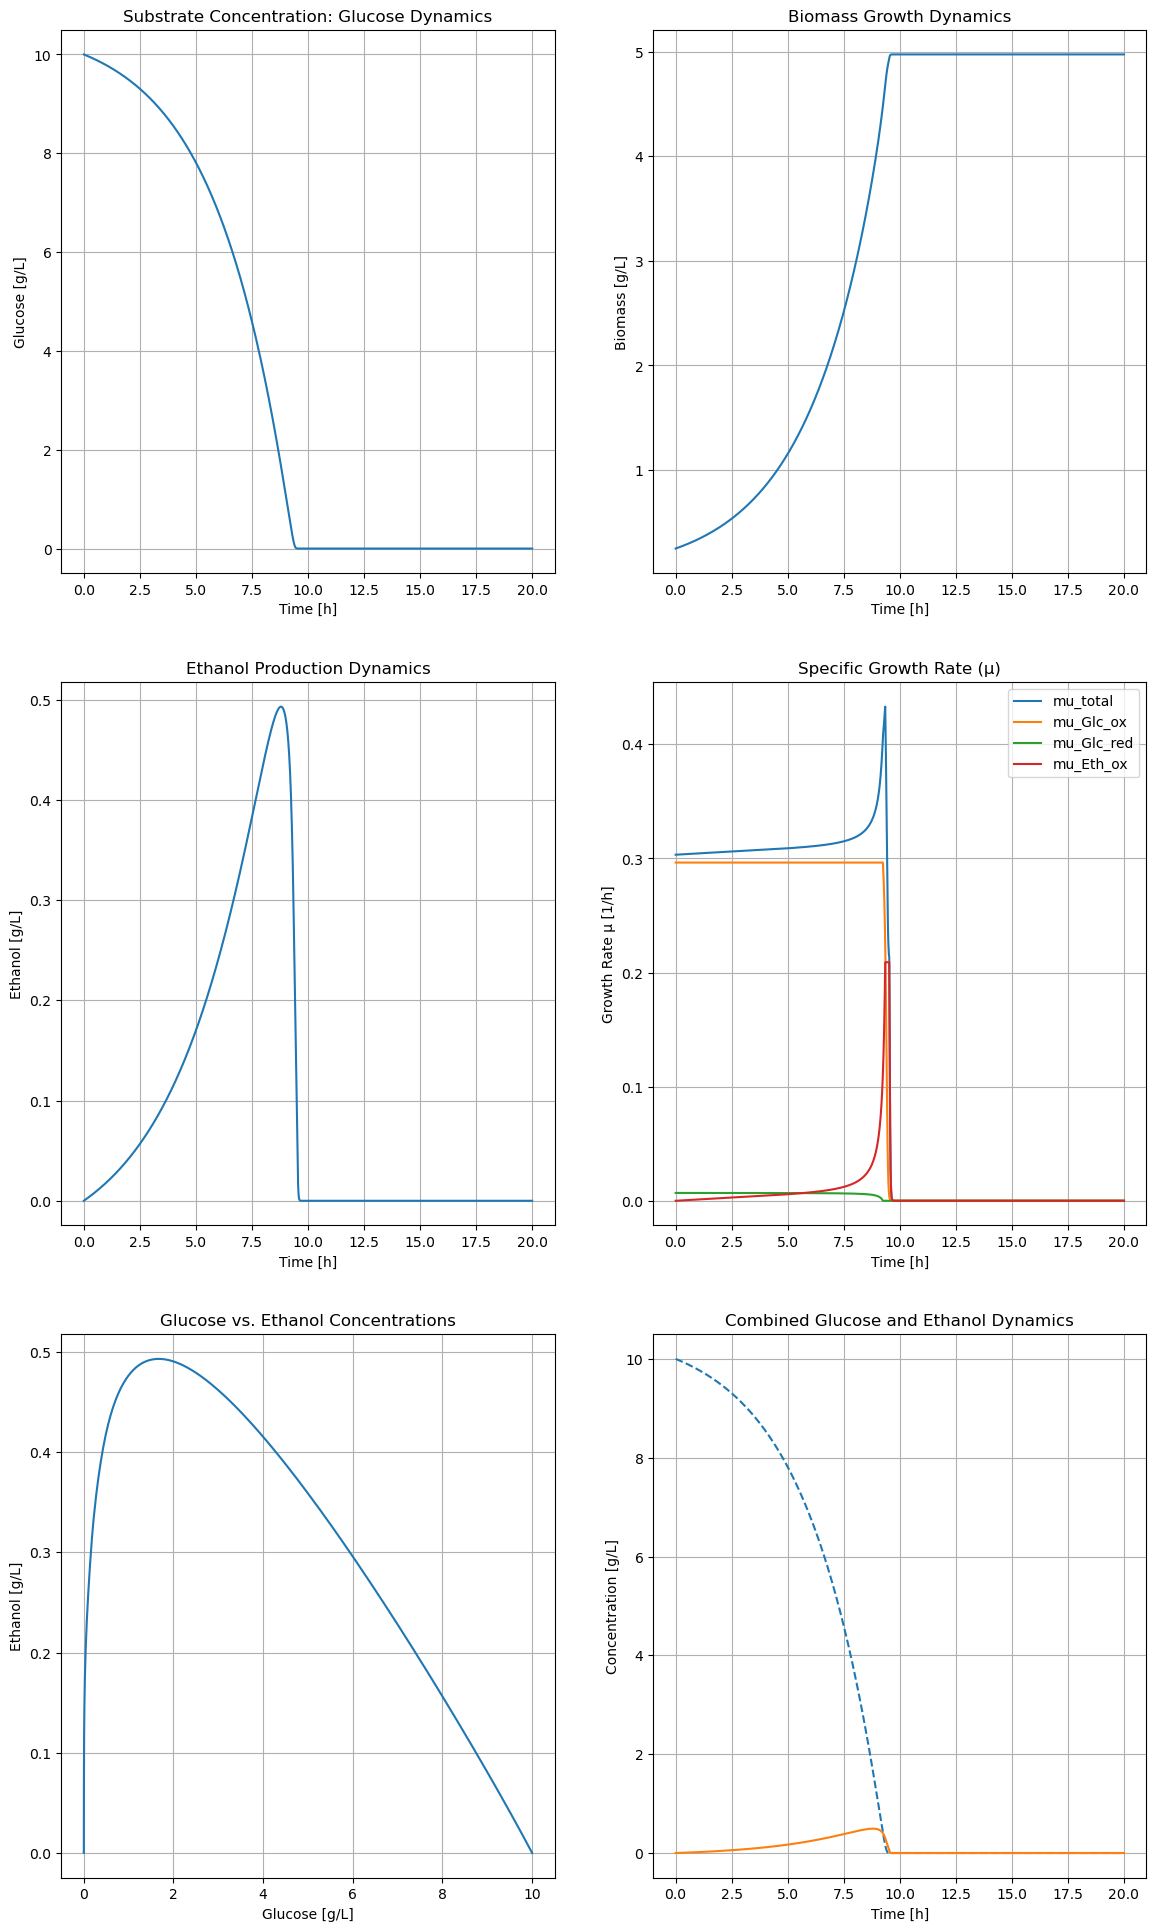

In [7]:
# Generate all plots
fig, axes = plt.subplots(3, 2, figsize=(14, 24))
axes = axes.flatten()

# Plot 1: Glucose Dynamics
# for label in results.keys():
    # axes[0].plot(results[label]["time"], results[label]["glucose"], label=f"{label}")
axes[0].plot(results["time"], results["glucose"])
axes[0].set_title("Substrate Concentration: Glucose Dynamics")
axes[0].set_xlabel("Time [h]")
axes[0].set_ylabel("Glucose [g/L]")
axes[0].grid()
# axes[0].legend()

# Plot 2: Biomass Dynamics
# for label in results.keys():
#     axes[1].plot(results[label]["time"], results[label]["biomass"], label=f"{label}")
axes[1].plot(results["time"], results["biomass"])
axes[1].set_title("Biomass Growth Dynamics")
axes[1].set_xlabel("Time [h]")
axes[1].set_ylabel("Biomass [g/L]")
axes[1].grid()
# axes[1].legend()

# Plot 3: Ethanol Dynamics
# for label in results.keys():
#     axes[2].plot(results[label]["time"], results[label]["ethanol"], label=f"{label}")
axes[2].plot(results["time"], results["ethanol"])
axes[2].set_title("Ethanol Production Dynamics")
axes[2].set_xlabel("Time [h]")
axes[2].set_ylabel("Ethanol [g/L]")
axes[2].grid()
# axes[2].legend()

# Plot 4: Specific Growth Rate (µ)
# for label in results.keys():
#     axes[3].plot(results[label]["time"], results[label]["mu"], label=f"{label}")
axes[3].plot(results["time"], results["mu"][0], label="mu_total")
axes[3].plot(results["time"], results["mu"][1][0], label="mu_Glc_ox")
axes[3].plot(results["time"], results["mu"][1][1], label="mu_Glc_red")
axes[3].plot(results["time"], results["mu"][1][2], label="mu_Eth_ox")
axes[3].set_title("Specific Growth Rate (µ)")
axes[3].set_xlabel("Time [h]")
axes[3].set_ylabel("Growth Rate µ [1/h]")
axes[3].grid()
axes[3].legend()

# Plot 5: Glucose vs. Ethanol Concentrations
# for label in results.keys():
#     axes[4].plot(results[label]["glucose"], results[label]["ethanol"], label=f"{label}")
axes[4].plot(results["glucose"], results["ethanol"])
axes[4].set_title("Glucose vs. Ethanol Concentrations")
axes[4].set_xlabel("Glucose [g/L]")
axes[4].set_ylabel("Ethanol [g/L]")
axes[4].grid()
# axes[4].legend()

# Plot 6: Combined Glucose and Ethanol Dynamics
# for label, res in results.items():
    # axes[5].plot(res["time"], res["glucose"], linestyle="dashed", label=f"Glucose - {label}")
    # axes[5].plot(res["time"], res["ethanol"], linestyle="solid", label=f"Ethanol - {label}")
axes[5].plot(results["time"], results["glucose"], linestyle="dashed")
axes[5].plot(results["time"], results["ethanol"], linestyle="solid")
axes[5].set_title("Combined Glucose and Ethanol Dynamics")
axes[5].set_xlabel("Time [h]")
axes[5].set_ylabel("Concentration [g/L]")
axes[5].grid()
# axes[5].legend()


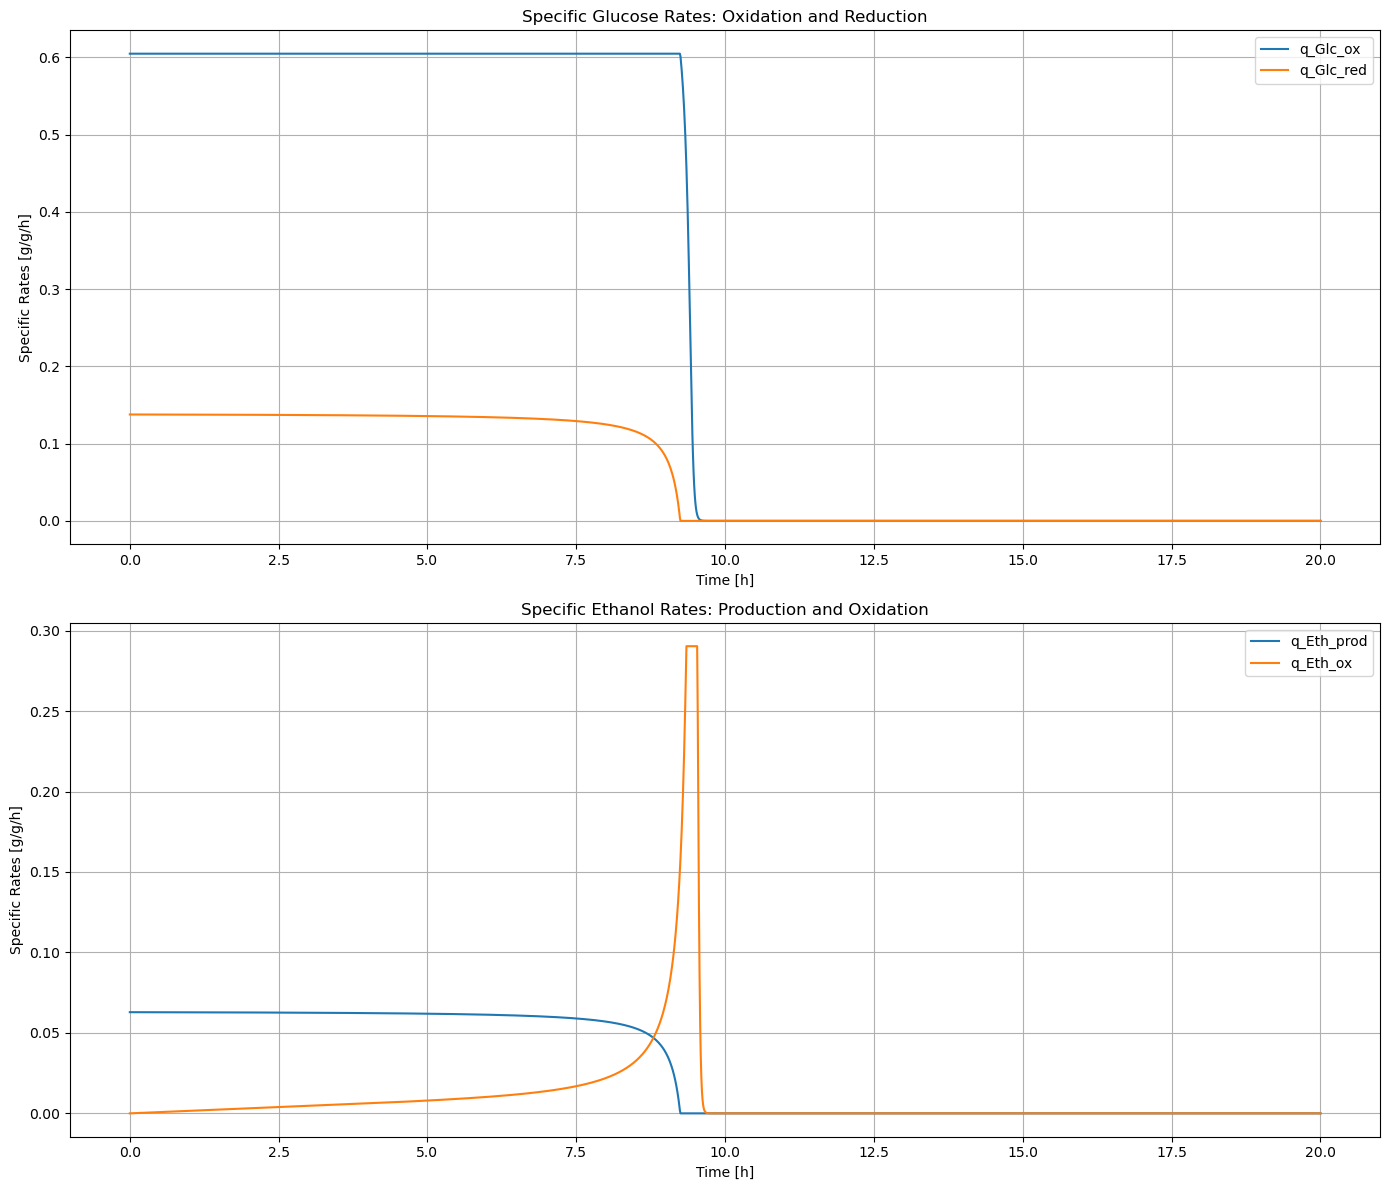

In [8]:
# Plot 7: Specific Rates (over 2 rows)
fig2, ax = plt.subplots(2, 1, figsize=(14, 12))

# for label in results.keys():
#     ax[0].plot(results[label]["time"], results[label]["q_Glc_ox"], label=f"q_Glc_ox - {label}")
#     ax[0].plot(results[label]["time"], results[label]["q_Glc_red"], label=f"q_Glc_red - {label}")
ax[0].plot(results["time"], results["q_Glc_ox"], label="q_Glc_ox")
ax[0].plot(results["time"], results["q_Glc_red"], label="q_Glc_red")
ax[0].set_title("Specific Glucose Rates: Oxidation and Reduction")
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("Specific Rates [g/g/h]")
ax[0].grid()
ax[0].legend()

# for label in results.keys():
#     ax[1].plot(results[label]["time"], results[label]["q_Eth_prod"], label=f"q_Eth_prod - {label}")
#     ax[1].plot(results[label]["time"], results[label]["q_Eth_ox"], label=f"q_Eth_ox - {label}")
ax[1].plot(results["time"], results["q_Eth_prod"], label="q_Eth_prod")
ax[1].plot(results["time"], results["q_Eth_ox"], label="q_Eth_ox")
ax[1].set_title("Specific Ethanol Rates: Production and Oxidation")
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Specific Rates [g/g/h]")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Define different scenarios for parameter variations
scenarios = {
    "Base": params,
    "Increased Both": {**params, "q_Glc_max": 3.0, "q_Eth_max": 1.5},
    "Decreased Both": {**params, "q_Glc_max": 2.0, "q_Eth_max": 0.5},
}

NameError: name 'params' is not defined

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

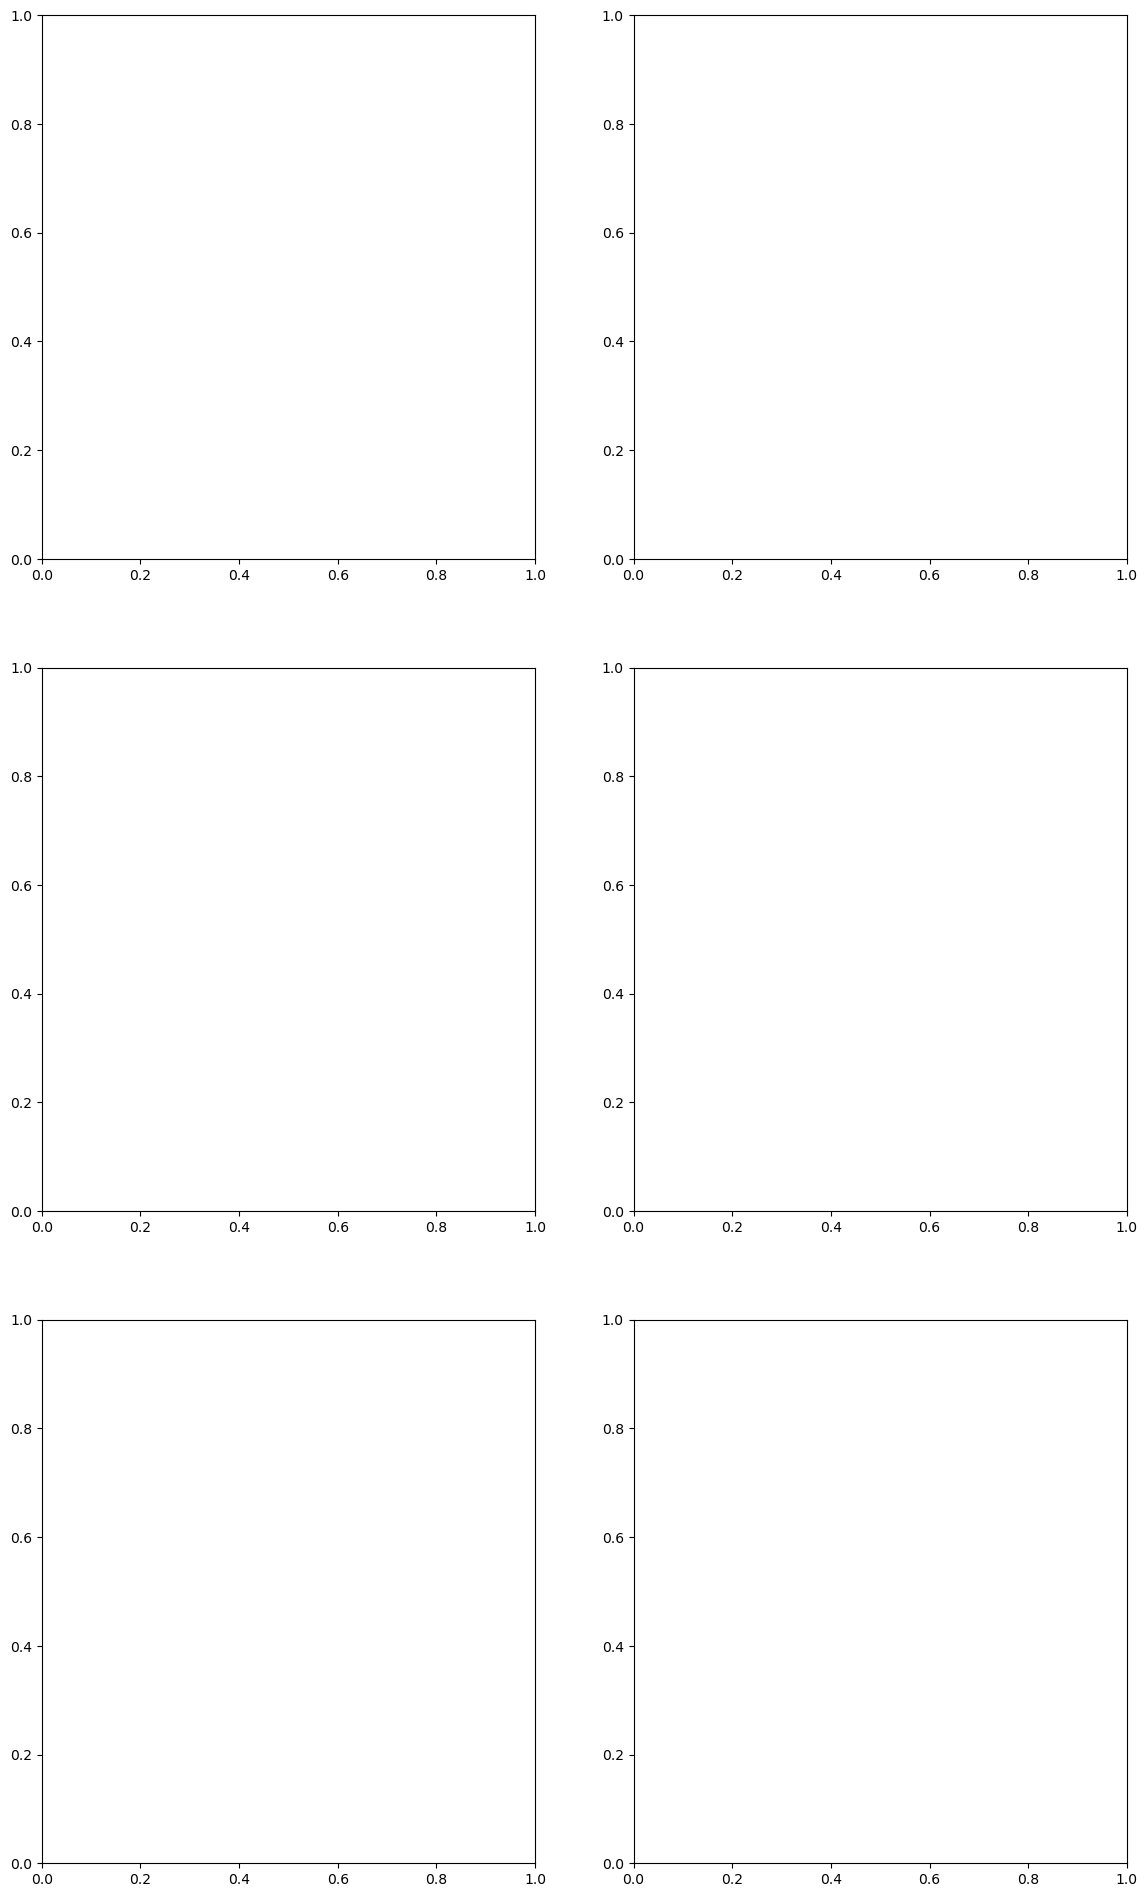

In [ ]:
# Generate all plots
fig, axes = plt.subplots(3, 2, figsize=(14, 24))
axes = axes.flatten()

# Plot 1: Glucose Dynamics
for label in results.keys():
    axes[0].plot(results[label]["time"], results[label]["glucose"], label=f"{label}")
axes[0].set_title("Substrate Concentration: Glucose Dynamics")
axes[0].set_xlabel("Time [h]")
axes[0].set_ylabel("Glucose [g/L]")
axes[0].grid()
axes[0].legend()

# Plot 2: Biomass Dynamics
for label in results.keys():
    axes[1].plot(results[label]["time"], results[label]["biomass"], label=f"{label}")
axes[1].set_title("Biomass Growth Dynamics")
axes[1].set_xlabel("Time [h]")
axes[1].set_ylabel("Biomass [g/L]")
axes[1].grid()
axes[1].legend()

# Plot 3: Ethanol Dynamics
for label in results.keys():
    axes[2].plot(results[label]["time"], results[label]["ethanol"], label=f"{label}")
axes[2].set_title("Ethanol Production Dynamics")
axes[2].set_xlabel("Time [h]")
axes[2].set_ylabel("Ethanol [g/L]")
axes[2].grid()
axes[2].legend()

# Plot 4: Specific Growth Rate (µ)
for label in results.keys():
    axes[3].plot(results[label]["time"], results[label]["mu"], label=f"{label}")
axes[3].set_title("Specific Growth Rate (µ)")
axes[3].set_xlabel("Time [h]")
axes[3].set_ylabel("Growth Rate µ [1/h]")
axes[3].grid()
axes[3].legend()

# Plot 5: Glucose vs. Ethanol Concentrations
for label in results.keys():
    axes[4].plot(results[label]["glucose"], results[label]["ethanol"], label=f"{label}")
axes[4].set_title("Glucose vs. Ethanol Concentrations")
axes[4].set_xlabel("Glucose [g/L]")
axes[4].set_ylabel("Ethanol [g/L]")
axes[4].grid()
axes[4].legend()

# Plot 6: Combined Glucose and Ethanol Dynamics
for label, res in results.items():
    axes[5].plot(res["time"], res["glucose"], linestyle="dashed", label=f"Glucose - {label}")
    axes[5].plot(res["time"], res["ethanol"], linestyle="solid", label=f"Ethanol - {label}")
axes[5].set_title("Combined Glucose and Ethanol Dynamics")
axes[5].set_xlabel("Time [h]")
axes[5].set_ylabel("Concentration [g/L]")
axes[5].grid()
axes[5].legend()

# Plot 7: Specific Rates (over 2 rows)
fig2, ax = plt.subplots(2, 1, figsize=(14, 12))
for label in results.keys():
    ax[0].plot(results[label]["time"], results[label]["qGlc_ox"], label=f"qGlc_ox - {label}")
    ax[0].plot(results[label]["time"], results[label]["qGlc_red"], label=f"qGlc_red - {label}")
ax[0].set_title("Specific Glucose Rates: Oxidation and Reduction")
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("Specific Rates [g/g/h]")
ax[0].grid()
ax[0].legend()

for label in results.keys():
    ax[1].plot(results[label]["time"], results[label]["qEth_prod"], label=f"qEth_prod - {label}")
    ax[1].plot(results[label]["time"], results[label]["qEth_ox"], label=f"qEth_ox - {label}")
ax[1].set_title("Specific Ethanol Rates: Production and Oxidation")
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Specific Rates [g/g/h]")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

thinking of that all what do you think is also important to mention? in the end the paper that i have to wirte about this plots will be 5 pages. You have the given theory. I want that the Pager is struktured in Introduction, Theory, Methodology, Results and Conculusion. Can you give me suggestions what to write about?